#**PROJET DEEP LEARNING**

##Equipe 5 : AZZOUZI Mouna - BERRADA Amine - CLAIN Nicolas - SO Absa - YEMELE Ivana

##**OBJECTIF : déterminer la note d'un produit à partir du titre de sa review**

###Imports nécessaires pour le projet

In [ ]:
import pandas as pd
import os
import shutil
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TextVectorization
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

### Création du dossier contenant notre jeu de données et des sous-dossier de train et de test

In [ ]:
if os.path.exists("reviews"):
    shutil.rmtree('reviews')
os.makedirs("reviews")

In [ ]:
os.makedirs("reviews/train")
os.makedirs("reviews/test")

###Téléchargement de notre jeu de données

In [ ]:
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Music_v1_00.tsv.gz"

dataset_dir = utils.get_file(
    origin=url,
    extract=True,
    cache_dir='./reviews',
    cache_subdir='')

1521994296/1521994296 [==============================] - 96s 0us/step


In [ ]:
!gzip -d /content/datasets/amazon_reviews_us_Music_v1_00.tsv.gz

gzip: /content/datasets/amazon_reviews_us_Music_v1_00.tsv.gz: No such file or directory


##Nettoyage de nos données
L'objectif ici est de créer un dataframe ne contenant que les titres de reviews et la note associée

In [ ]:
df = pd.read_table('reviews/amazon_reviews_us_Music_v1_00.tsv.gz', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 1806: expected 15 fields, saw 22\n'
b'Skipping line 122830: expected 15 fields, saw 22\nSkipping line 128573: expected 15 fields, saw 22\n'
b'Skipping line 132725: expected 15 fields, saw 22\nSkipping line 139782: expected 15 fields, saw 22\nSkipping line 141362: expected 15 fields, saw 22\nSkipping line 151132: expected 15 fields, saw 22\nSkipping line 168466: expected 15 fields, saw 22\nSkipping line 171654: expected 15 fields, saw 22\nSkipping line 178479: expected 15 fields, saw 22\nSkipping line 179537: expected 15 fields, saw 22\nSkipping line 190573: expected 15 fields, saw 22\n'
b'Skipping line 205670: expected 15 fields, saw 22\nSkipping line 229584: expected 15 fields, saw 22\nSkipping line 241528: expected 15 fields, saw 22\n'

In [ ]:
df= df.dropna()

In [ ]:
df = df[['review_headline', 'star_rating']]
df

,review_headline,star_rating
0,Five Stars,5
1,A new fave in our house,5
2,Five Stars,5
3,Three Stars,3
4,Five Stars,5
...,...,...
4740844,Excellent! Melodic; superb vocal harmonies! A ...,5
4740845,The upmost delightful sound collection you can...,5
4740846,Wonderful Celtic/American folk,5
4740847,Kiss' return to hard rock from Disco. One of t...,4


In [ ]:
df = df.reset_index(drop=True)
df

,review_headline,star_rating
0,Five Stars,5
1,A new fave in our house,5
2,Five Stars,5
3,Three Stars,3
4,Five Stars,5
...,...,...
4740224,Excellent! Melodic; superb vocal harmonies! A ...,5
4740225,The upmost delightful sound collection you can...,5
4740226,Wonderful Celtic/American folk,5
4740227,Kiss' return to hard rock from Disco. One of t...,4


In [ ]:
list_headlines = df['review_headline'].unique()
list_ratings = df['star_rating'].unique()

##Remplissage des sous-dossiers de train et de test
L'objectif ici est de créer dans chacun des sous-dossiers "train" et "test", un sous-dossier par note, et dans chacun de ces sous-dossiers, créer un fichier par un review et dont le contenu est le titre de la review.

In [ ]:
j = 1
max_headlines = 2000
nb_labels = 5
for rating in list_ratings:
    folder_path_train = "reviews/train/" + str(rating)
    os.makedirs(folder_path_train)
    folder_path_test = "reviews/test/" + str(rating)
    os.makedirs(folder_path_test)
    rating_headlines = df[df['star_rating'] == rating]
    i = 0
    for index_headline, headline in rating_headlines.iterrows():
        if i < max_headlines:
            path = folder_path_train + "/" + str(i) + ".txt"
            f = open(path, "w+", encoding="utf-8")
            f.write(str(headline["review_headline"]))
            f.close()
        if i > max_headlines :
            path = folder_path_test + "/" + str(i) + ".txt"
            f = open(path, "w+", encoding="utf-8")
            f.write(str(headline["review_headline"]))
            f.close()
        if i > 2 * max_headlines:
            break

        i += 1
    if j >= nb_labels:
        break
    j+=1

##Création des batches d'entraînement, de test et de validation

In [ ]:
batch_size = 32
validation_size_percentage = 0.2
seed = 40 

train_batch = utils.text_dataset_from_directory(
    "reviews/train",
    batch_size=batch_size,
    validation_split= validation_size_percentage,
    subset='training',
    seed=seed)

validation_batch = utils.text_dataset_from_directory(
    "reviews/train",
    batch_size=batch_size,
    validation_split= validation_size_percentage,
    subset='validation',
    seed=seed)

test_batch = utils.text_dataset_from_directory(
    "reviews/test",
    batch_size=batch_size)

Found 10000 files belonging to 5 classes.
Using 8000 files for training.
Found 10000 files belonging to 5 classes.
Using 2000 files for validation.
Found 10005 files belonging to 5 classes.


##Préparation aux vectorisations

In [ ]:
vocabulary_size = 20000
max_sequence_length = 20

##Essai avec la binary vectorization

In [ ]:
binary_vectorize_layer = TextVectorization(
    max_tokens=vocabulary_size,
    output_mode='binary')

train_text = train_batch.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)

In [ ]:
def binary_vectorize(text, label):
    text = tf.expand_dims(text, -1)
    return binary_vectorize_layer(text), label

In [ ]:
binary_train_batch = train_batch.map(binary_vectorize)
binary_validation_batch = validation_batch.map(binary_vectorize)
binary_test_batch = test_batch.map(binary_vectorize)

Model number  1
Epoch 1/10
250/250 [==============================] - 284s 1s/step - loss: 1.3789 - accuracy: 0.4230 - val_loss: 1.2957 - val_accuracy: 0.4525
Epoch 2/10
250/250 [==============================] - 290s 1s/step - loss: 1.2719 - accuracy: 0.4499 - val_loss: 1.2459 - val_accuracy: 0.4455
Epoch 3/10
250/250 [==============================] - 282s 1s/step - loss: 1.2571 - accuracy: 0.4582 - val_loss: 1.2239 - val_accuracy: 0.4510
Epoch 4/10
250/250 [==============================] - 284s 1s/step - loss: 1.2428 - accuracy: 0.4595 - val_loss: 1.2184 - val_accuracy: 0.4485
Epoch 5/10
250/250 [==============================] - 281s 1s/step - loss: 1.2324 - accuracy: 0.4641 - val_loss: 1.2139 - val_accuracy: 0.4505
Epoch 6/10
250/250 [==============================] - 282s 1s/step - loss: 1.2325 - accuracy: 0.4597 - val_loss: 1.2134 - val_accuracy: 0.4525
Epoch 7/10
250/250 [==============================] - 280s 1s/step - loss: 1.2299 - accuracy: 0.4576 - val_loss: 1.2296 - val_

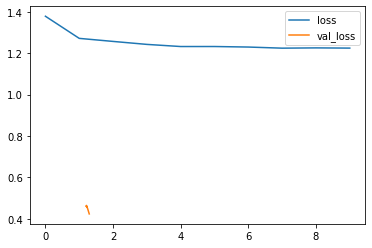

313/313 [==============================] - 93s 297ms/step - loss: 1.2068 - accuracy: 0.4435
Int model accuracy: 44.35%
Model number  2
Epoch 1/10
250/250 [==============================] - 277s 1s/step - loss: 1.4435 - accuracy: 0.3931 - val_loss: 1.3011 - val_accuracy: 0.4480
Epoch 2/10
250/250 [==============================] - 272s 1s/step - loss: 1.3276 - accuracy: 0.4507 - val_loss: 1.2652 - val_accuracy: 0.4440
Epoch 3/10
250/250 [==============================] - 271s 1s/step - loss: 1.2990 - accuracy: 0.4555 - val_loss: 1.2647 - val_accuracy: 0.4505
Epoch 4/10
250/250 [==============================] - 273s 1s/step - loss: 1.2885 - accuracy: 0.4611 - val_loss: 1.2480 - val_accuracy: 0.4485
Epoch 5/10
250/250 [==============================] - 274s 1s/step - loss: 1.2791 - accuracy: 0.4574 - val_loss: 1.2504 - val_accuracy: 0.4470
Epoch 6/10
250/250 [==============================] - 272s 1s/step - loss: 1.2830 - accuracy: 0.4515 - val_loss: 1.2438 - val_accuracy: 0.4480
Epoch 7

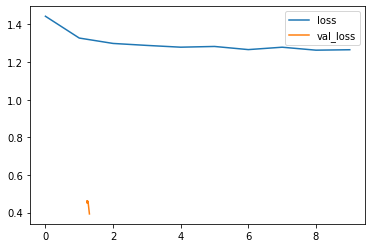

313/313 [==============================] - 90s 287ms/step - loss: 1.2432 - accuracy: 0.4441
Int model accuracy: 44.41%
Model number  3
Epoch 1/10
250/250 [==============================] - 274s 1s/step - loss: 1.4990 - accuracy: 0.3561 - val_loss: 1.3611 - val_accuracy: 0.4505
Epoch 2/10
250/250 [==============================] - 271s 1s/step - loss: 1.3742 - accuracy: 0.4305 - val_loss: 1.3018 - val_accuracy: 0.4485
Epoch 3/10
250/250 [==============================] - 270s 1s/step - loss: 1.3636 - accuracy: 0.4376 - val_loss: 1.2972 - val_accuracy: 0.4480
Epoch 4/10
250/250 [==============================] - 267s 1s/step - loss: 1.3473 - accuracy: 0.4445 - val_loss: 1.2874 - val_accuracy: 0.4505
Epoch 5/10
250/250 [==============================] - 268s 1s/step - loss: 1.3440 - accuracy: 0.4524 - val_loss: 1.2799 - val_accuracy: 0.4490
Epoch 6/10
250/250 [==============================] - 267s 1s/step - loss: 1.3365 - accuracy: 0.4530 - val_loss: 1.2791 - val_accuracy: 0.4475
Epoch 7

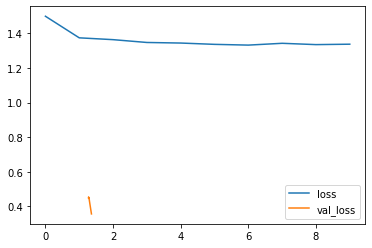

313/313 [==============================] - 87s 279ms/step - loss: 1.2811 - accuracy: 0.4435
Int model accuracy: 44.35%
Model number  4
Epoch 1/10
250/250 [==============================] - 268s 1s/step - loss: 1.5400 - accuracy: 0.3146 - val_loss: 1.4276 - val_accuracy: 0.4475
Epoch 2/10
250/250 [==============================] - 269s 1s/step - loss: 1.4435 - accuracy: 0.3855 - val_loss: 1.3638 - val_accuracy: 0.4530
Epoch 3/10
250/250 [==============================] - 266s 1s/step - loss: 1.4275 - accuracy: 0.4065 - val_loss: 1.3475 - val_accuracy: 0.4500
Epoch 4/10
250/250 [==============================] - 266s 1s/step - loss: 1.4037 - accuracy: 0.4243 - val_loss: 1.3461 - val_accuracy: 0.4535
Epoch 5/10
250/250 [==============================] - 266s 1s/step - loss: 1.4059 - accuracy: 0.4297 - val_loss: 1.3400 - val_accuracy: 0.4475
Epoch 6/10
250/250 [==============================] - 268s 1s/step - loss: 1.3982 - accuracy: 0.4240 - val_loss: 1.3262 - val_accuracy: 0.4465
Epoch 7

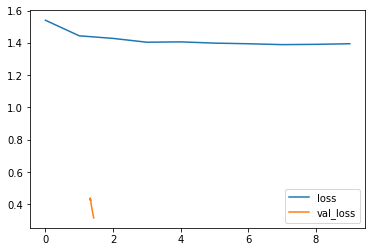

313/313 [==============================] - 86s 276ms/step - loss: 1.3269 - accuracy: 0.4411
Int model accuracy: 44.11%


In [ ]:
vocab_size=vocabulary_size + 1
num_labels = 5

list_dropouts = [0.2, 0.4, 0.6, 0.8]

for i in range(len(list_dropouts)):
  print("Model number ", i+1)
  int_model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 128 , mask_zero=True),
      layers.Conv1D(128, 5, padding="causal", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dropout(list_dropouts[i]),
      layers.Dense(num_labels)
    ])
  int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='RMSprop',
    metrics=['accuracy'])
  history = int_model.fit(binary_train_batch, validation_data=binary_validation_batch, epochs=10)
  print(int_model.summary())
  metrics = history.history # comprend l'historiques des epochs : % accuracy pour chaque epoch, utilisé dans le plot
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'], metrics['accuracy'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
  int_loss, int_accuracy = int_model.evaluate(binary_test_batch)
  print("Int model accuracy: {:2.2%}".format(int_accuracy))
  print("==================================================")

La binary vectorization de donne pas de résultat satisfaisant. Nous décidons donc de passer à l'int vectorization.

##Essai avec la int vectorization

In [ ]:
int_vectorize_layer = TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=max_sequence_length,
    output_mode='int')

train_text = train_batch.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)

In [ ]:
def int_vectorize(text, label):
    text = tf.expand_dims(text, -1)
    return int_vectorize_layer(text), label

In [ ]:
int_train_batch = train_batch.map(int_vectorize)
int_validation_batch = validation_batch.map(int_vectorize)
int_test_batch = test_batch.map(int_vectorize)

Première tentative : jouer sur la valeur du dropout

Model number  1
Epoch 1/5
250/250 [==============================] - 12s 44ms/step - loss: 1.0321 - accuracy: 0.5615 - val_loss: 0.9112 - val_accuracy: 0.5965
Epoch 2/5
250/250 [==============================] - 11s 42ms/step - loss: 0.8130 - accuracy: 0.6871 - val_loss: 0.8800 - val_accuracy: 0.6135
Epoch 3/5
250/250 [==============================] - 11s 45ms/step - loss: 0.6776 - accuracy: 0.7614 - val_loss: 0.8969 - val_accuracy: 0.6105
Epoch 4/5
250/250 [==============================] - 11s 42ms/step - loss: 0.5556 - accuracy: 0.8174 - val_loss: 0.9483 - val_accuracy: 0.6095
Epoch 5/5
250/250 [==============================] - 11s 42ms/step - loss: 0.4504 - accuracy: 0.8568 - val_loss: 1.0079 - val_accuracy: 0.6085
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 128)         2560128   
                                                 

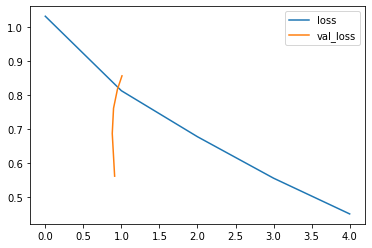

313/313 [==============================] - 4s 13ms/step - loss: 1.0273 - accuracy: 0.6077
Int model accuracy: 60.77%
Model number  2
Epoch 1/5
250/250 [==============================] - 13s 47ms/step - loss: 1.0559 - accuracy: 0.5531 - val_loss: 0.9258 - val_accuracy: 0.5920
Epoch 2/5
250/250 [==============================] - 11s 46ms/step - loss: 0.8387 - accuracy: 0.6689 - val_loss: 0.8827 - val_accuracy: 0.6080
Epoch 3/5
250/250 [==============================] - 11s 42ms/step - loss: 0.7078 - accuracy: 0.7445 - val_loss: 0.8873 - val_accuracy: 0.6105
Epoch 4/5
250/250 [==============================] - 11s 42ms/step - loss: 0.5951 - accuracy: 0.7956 - val_loss: 0.9251 - val_accuracy: 0.6110
Epoch 5/5
250/250 [==============================] - 11s 42ms/step - loss: 0.4994 - accuracy: 0.8338 - val_loss: 0.9685 - val_accuracy: 0.6065
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

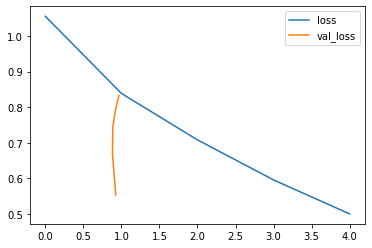

313/313 [==============================] - 4s 13ms/step - loss: 0.9989 - accuracy: 0.6090
Int model accuracy: 60.90%
Model number  3
Epoch 1/5
250/250 [==============================] - 12s 46ms/step - loss: 1.0821 - accuracy: 0.5450 - val_loss: 0.9365 - val_accuracy: 0.5875
Epoch 2/5
250/250 [==============================] - 11s 42ms/step - loss: 0.8715 - accuracy: 0.6554 - val_loss: 0.8909 - val_accuracy: 0.6055
Epoch 3/5
250/250 [==============================] - 11s 42ms/step - loss: 0.7582 - accuracy: 0.7172 - val_loss: 0.8867 - val_accuracy: 0.6105
Epoch 4/5
250/250 [==============================] - 11s 42ms/step - loss: 0.6669 - accuracy: 0.7656 - val_loss: 0.9094 - val_accuracy: 0.6095
Epoch 5/5
250/250 [==============================] - 11s 42ms/step - loss: 0.5807 - accuracy: 0.8020 - val_loss: 0.9419 - val_accuracy: 0.6075
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

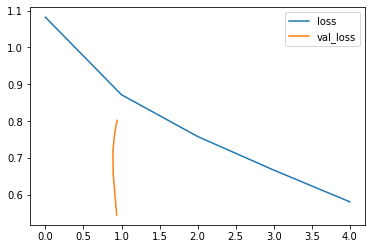

313/313 [==============================] - 4s 13ms/step - loss: 0.9717 - accuracy: 0.6153
Int model accuracy: 61.53%
Model number  4
Epoch 1/5
250/250 [==============================] - 12s 45ms/step - loss: 1.1481 - accuracy: 0.5211 - val_loss: 0.9528 - val_accuracy: 0.5705
Epoch 2/5
250/250 [==============================] - 11s 44ms/step - loss: 0.9288 - accuracy: 0.6165 - val_loss: 0.9025 - val_accuracy: 0.5935
Epoch 3/5
250/250 [==============================] - 10s 42ms/step - loss: 0.8463 - accuracy: 0.6719 - val_loss: 0.8828 - val_accuracy: 0.6115
Epoch 4/5
250/250 [==============================] - 11s 45ms/step - loss: 0.7715 - accuracy: 0.7089 - val_loss: 0.8860 - val_accuracy: 0.6050
Epoch 5/5
250/250 [==============================] - 11s 43ms/step - loss: 0.7232 - accuracy: 0.7423 - val_loss: 0.8984 - val_accuracy: 0.5975
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param # 

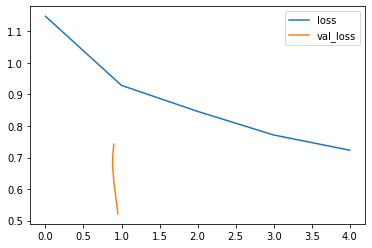

313/313 [==============================] - 4s 13ms/step - loss: 0.9338 - accuracy: 0.6133
Int model accuracy: 61.33%


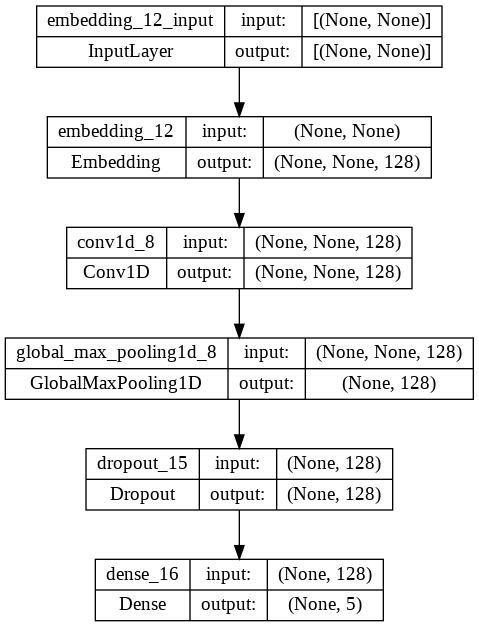

In [ ]:
vocab_size=vocabulary_size

list_dropouts = [0.2, 0.4, 0.6, 0.8]

lostListDropouts = []
accuracyListDropouts = []

for i in range(len(list_dropouts)):
  print("Model number ", i+1)
  int_model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dropout(list_dropouts[i]),
      layers.Dense(num_labels)
  ])

  int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='RMSprop',
    metrics=['accuracy'])
  history = int_model.fit(int_train_batch, validation_data=int_validation_batch, epochs=5)
  print(int_model.summary())
  metrics = history.history # comprend l'historiques des epochs : % accuracy pour chaque epoch, utilisé dans le plot
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
  int_loss, int_accuracy = int_model.evaluate(int_test_batch)
  lostListDropouts.append(int_loss)
  accuracyListDropouts.append(int_accuracy)
  print("Int model accuracy: {:2.2%}".format(int_accuracy))
  print("==================================================")

print('Accuracies: ', accuracyListDropouts)
print('Losses: ', lostListDropouts)

La meilleur valeur de dropout semble être de 0.2

Deuxième tentative : jouer sur l'optimizer

Model number  1
Epoch 1/4
250/250 [==============================] - 11s 43ms/step - loss: 2.5943 - accuracy: 0.2679 - val_loss: 1.7179 - val_accuracy: 0.3045
Epoch 2/4
250/250 [==============================] - 11s 43ms/step - loss: 2.2021 - accuracy: 0.2835 - val_loss: 1.6280 - val_accuracy: 0.3075
Epoch 3/4
250/250 [==============================] - 11s 43ms/step - loss: 2.1765 - accuracy: 0.2894 - val_loss: 1.6013 - val_accuracy: 0.3125
Epoch 4/4
250/250 [==============================] - 11s 43ms/step - loss: 2.1196 - accuracy: 0.3061 - val_loss: 1.6030 - val_accuracy: 0.3125
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, None, 128)         2560128   
                                                                 
 conv1d_9 (Conv1D)           (None, None, 128)         82048     
                                                           

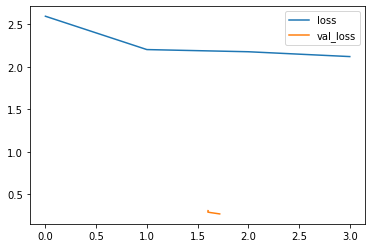

313/313 [==============================] - 4s 13ms/step - loss: 1.6054 - accuracy: 0.3184
Int model accuracy: 31.84%
Model number  2
Epoch 1/4
250/250 [==============================] - 12s 44ms/step - loss: 3.1420 - accuracy: 0.2592 - val_loss: 1.9869 - val_accuracy: 0.3690
Epoch 2/4
250/250 [==============================] - 12s 49ms/step - loss: 2.7982 - accuracy: 0.2905 - val_loss: 1.8103 - val_accuracy: 0.3835
Epoch 3/4
250/250 [==============================] - 11s 45ms/step - loss: 2.7581 - accuracy: 0.2977 - val_loss: 1.7688 - val_accuracy: 0.3845
Epoch 4/4
250/250 [==============================] - 11s 44ms/step - loss: 2.6857 - accuracy: 0.3160 - val_loss: 1.7233 - val_accuracy: 0.3865
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 128)         2560128   
                                                                 
 conv1d_

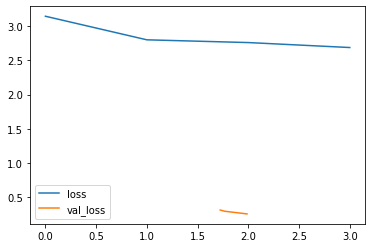

313/313 [==============================] - 5s 15ms/step - loss: 1.7168 - accuracy: 0.3876
Int model accuracy: 38.76%
Model number  3
Epoch 1/4
250/250 [==============================] - 12s 44ms/step - loss: 3.5865 - accuracy: 0.2674 - val_loss: 2.4253 - val_accuracy: 0.4300
Epoch 2/4
250/250 [==============================] - 12s 47ms/step - loss: 3.3189 - accuracy: 0.2859 - val_loss: 2.0115 - val_accuracy: 0.4770
Epoch 3/4
250/250 [==============================] - 11s 44ms/step - loss: 3.3332 - accuracy: 0.2855 - val_loss: 1.9331 - val_accuracy: 0.4435
Epoch 4/4
250/250 [==============================] - 11s 44ms/step - loss: 3.2999 - accuracy: 0.2976 - val_loss: 1.9145 - val_accuracy: 0.4505
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, None, 128)         2560128   
                                                                 
 conv1d_

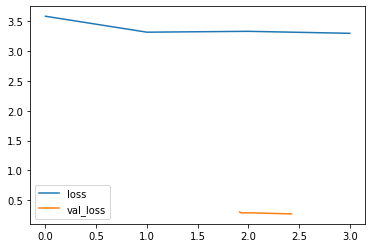

313/313 [==============================] - 4s 13ms/step - loss: 1.8929 - accuracy: 0.4689
Int model accuracy: 46.89%
Model number  4
Epoch 1/4
250/250 [==============================] - 12s 44ms/step - loss: 4.1887 - accuracy: 0.2195 - val_loss: 3.2306 - val_accuracy: 0.5140
Epoch 2/4
250/250 [==============================] - 11s 43ms/step - loss: 4.0745 - accuracy: 0.2276 - val_loss: 2.8302 - val_accuracy: 0.5340
Epoch 3/4
250/250 [==============================] - 11s 43ms/step - loss: 4.0563 - accuracy: 0.2294 - val_loss: 2.6033 - val_accuracy: 0.5385
Epoch 4/4
250/250 [==============================] - 11s 43ms/step - loss: 4.0328 - accuracy: 0.2330 - val_loss: 2.5050 - val_accuracy: 0.5440
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 128)         2560128   
                                                                 
 conv1d_

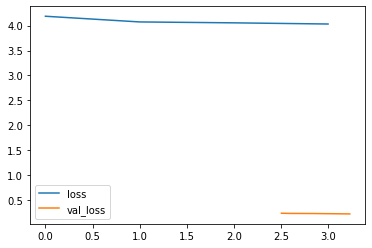

313/313 [==============================] - 4s 13ms/step - loss: 2.5052 - accuracy: 0.5428
Int model accuracy: 54.28%


In [ ]:
vocab_size=vocabulary_size

list_optimizers = ['RMSprop', 'Adam', 'Adagrad', 'Ftrl', 'Nadam']

lostListOptimizers = []
accuracyListOptimizers = []

for i in range(len(list_optimizers)):
  print("Model number ", i+1)
  int_model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dropout(0.2),
      layers.Dense(num_labels)
  ])

  int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=list_optimizers[i],
    metrics=['accuracy'])
  history = int_model.fit(int_train_batch, validation_data=int_validation_batch, epochs=5)
  print(int_model.summary())
  metrics = history.history # comprend l'historiques des epochs : % accuracy pour chaque epoch, utilisé dans le plot
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
  int_loss, int_accuracy = int_model.evaluate(int_test_batch)
  lostListOptimizers.append(int_loss)
  accuracyListOptimizers.append(int_accuracy)
  print("Int model accuracy: {:2.2%}".format(int_accuracy))
  print("==================================================")

print('Accuracies: ', accuracyListOptimizers)
print('Losses: ', lostListOptimizers)

L'optimizer le plus adapté semble être Adagrad.
Pour confirmer l'hypothèse, nous allons lancer un grand nombre d'epochs pour voir si la val_loss diminie au fil des itérations.

Model number  1
Epoch 1/200
250/250 [==============================] - 3s 11ms/step - loss: 1.6056 - accuracy: 0.2965 - val_loss: 1.6027 - val_accuracy: 0.4115
Epoch 2/200
250/250 [==============================] - 2s 10ms/step - loss: 1.5993 - accuracy: 0.3631 - val_loss: 1.5973 - val_accuracy: 0.4185
Epoch 3/200
250/250 [==============================] - 3s 11ms/step - loss: 1.5937 - accuracy: 0.4005 - val_loss: 1.5924 - val_accuracy: 0.4160
Epoch 4/200
250/250 [==============================] - 3s 11ms/step - loss: 1.5891 - accuracy: 0.4277 - val_loss: 1.5875 - val_accuracy: 0.5025
Epoch 5/200
250/250 [==============================] - 3s 10ms/step - loss: 1.5831 - accuracy: 0.4565 - val_loss: 1.5825 - val_accuracy: 0.5015
Epoch 6/200
250/250 [==============================] - 3s 11ms/step - loss: 1.5783 - accuracy: 0.4728 - val_loss: 1.5775 - val_accuracy: 0.5025
Epoch 7/200
250/250 [==============================] - 3s 11ms/step - loss: 1.5730 - accuracy: 0.4863 - val_loss: 1.5722

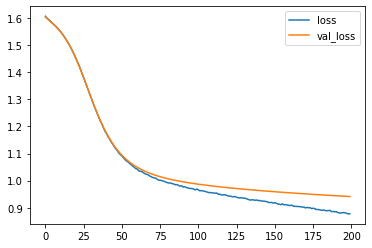

313/313 [==============================] - 2s 8ms/step - loss: 0.9471 - accuracy: 0.5828
Int model accuracy: 58.28%
Accuracies:  [0.5828086137771606]
Losses:  [0.9470803737640381]


In [ ]:
vocab_size=vocabulary_size

lostList = []
accuracyList = []

for i in range(len(list_optimizers)):
  print("Model number ", i+1)
  int_model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dropout(0.2),
      layers.Dense(num_labels)
  ])

  int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='Adagrad',
    metrics=['accuracy'])
  history = int_model.fit(int_train_batch, validation_data=int_validation_batch, epochs=200)
  print(int_model.summary())
  metrics = history.history # comprend l'historiques des epochs : % accuracy pour chaque epoch, utilisé dans le plot
  plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
  plt.legend(['loss', 'val_loss'])
  plt.show()
  int_loss, int_accuracy = int_model.evaluate(int_test_batch)
  lostList.append(int_loss)
  accuracyList.append(int_accuracy)
  print("Int model accuracy: {:2.2%}".format(int_accuracy))
  print("==================================================")
  break;

print('Accuracies: ', accuracyList)
print('Losses: ', lostList)

  Pour un grand nombre d'epochs avec Adagrad, les courbes de loss et de val_loss obtenues semblent cohérentes (elles diminuent) mais la valeur des pertes reste trop élevée.
  Nous choisissons donc d'utiliser l'optimizer RMSprop.

  Cette fois, nous jouerons sur le nombre de couches

Epoch 1/5
250/250 [==============================] - 6s 18ms/step - loss: 1.2124 - accuracy: 0.4207 - val_loss: 0.9841 - val_accuracy: 0.5595
Epoch 2/5
250/250 [==============================] - 4s 18ms/step - loss: 0.8665 - accuracy: 0.6299 - val_loss: 0.9445 - val_accuracy: 0.5865
Epoch 3/5
250/250 [==============================] - 5s 18ms/step - loss: 0.7197 - accuracy: 0.7089 - val_loss: 0.9982 - val_accuracy: 0.5785
Epoch 4/5
250/250 [==============================] - 5s 18ms/step - loss: 0.5894 - accuracy: 0.7692 - val_loss: 1.1134 - val_accuracy: 0.5765
Epoch 5/5
250/250 [==============================] - 5s 18ms/step - loss: 0.4784 - accuracy: 0.8273 - val_loss: 1.2418 - val_accuracy: 0.5825


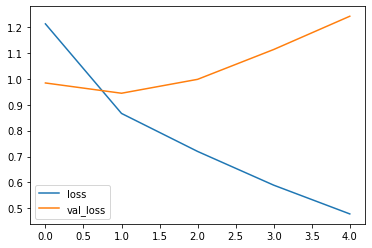

313/313 [==============================] - 2s 8ms/step - loss: 0.9471 - accuracy: 0.5828
Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_56 (Embedding)    (None, None, 64)          1280064   
                                                                 
 conv1d_56 (Conv1D)          (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_56 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_58 (Dense)            (None, 5)                 325       
                                                                 
 dense_59 (Dense)            (None, 5)                 30        
                                                                 
 dense_60 (Dense)            (

In [ ]:
vocab_size=vocabulary_size + 1

lostList = []
accuracyList = []

model3 = tf.keras.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=True),
    layers.Conv1D(64, 5, padding="causal", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dense(nb_labels),
    layers.Dense(nb_labels),
    layers.Dense(nb_labels),
    layers.Dense(nb_labels),
    layers.Dense(nb_labels),
    layers.Dense(nb_labels)
  ])

model3.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='RMSprop',
    metrics=['accuracy'])

history3 = model3.fit(int_train_batch, validation_data=int_validation_batch, epochs=5)
metrics = history3.history # comprend l'historiques des epochs : % accuracy pour chaque epoch, utilisé dans le plot
plt.plot(history3.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
int_loss, int_accuracy = int_model.evaluate(int_test_batch)
lostList.append(int_loss)
accuracyList.append(int_accuracy)
print(model3.summary())


print('Accuracies: ', accuracyList)
print('Losses: ', lostList)

In [ ]:
summary = pd.DataFrame(list(zip(accuracyListDropouts, lostListDropouts, accuracyListOptimizers, lostListOptimizers)), columns = ["AccuracyDropouts", "LossesDropouts", "AccuracyOptimizers", "LossesOptimizers"])
summary

,AccuracyDropouts,LossesDropouts,AccuracyOptimizers,LossesOptimizers
0,0.608696,0.945830,0.609395,0.946230
1,0.614193,0.928212,0.601699,1.103255
2,0.612894,0.919599,0.510345,1.586806
3,0.608596,0.919751,0.200000,1.609439


Le modèle ci-dessous semble donner les meilleurs résultats :

Epoch 1/5
250/250 [==============================] - 4s 13ms/step - loss: 1.2532 - accuracy: 0.4939 - val_loss: 0.9971 - val_accuracy: 0.5615
Epoch 2/5
250/250 [==============================] - 3s 14ms/step - loss: 0.9264 - accuracy: 0.6156 - val_loss: 0.9304 - val_accuracy: 0.5795
Epoch 3/5
250/250 [==============================] - 4s 17ms/step - loss: 0.8454 - accuracy: 0.6704 - val_loss: 0.9088 - val_accuracy: 0.5980
Epoch 4/5
250/250 [==============================] - 3s 13ms/step - loss: 0.7815 - accuracy: 0.7041 - val_loss: 0.9059 - val_accuracy: 0.6000
Epoch 5/5
250/250 [==============================] - 3s 13ms/step - loss: 0.7235 - accuracy: 0.7411 - val_loss: 0.9088 - val_accuracy: 0.5945
Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_68 (Embedding)    (None, None, 32)          640032    
                                                                 
 co

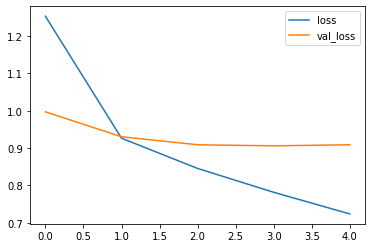

In [ ]:
vocab_size=vocabulary_size + 1

int_model1 = tf.keras.Sequential([
    layers.Embedding(vocab_size, 32, mask_zero=True),
    layers.Conv1D(32, 5, padding="causal", activation="relu", strides=2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.2),
    layers.Dense(nb_labels)
  ])

int_model1.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='RMSprop',
    metrics=['accuracy'])
history = int_model1.fit(int_train_batch, validation_data=int_validation_batch, epochs=5)
print(int_model1.summary())
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

On s'attelle ensuite à la prédiction avec le modèle ci-dessus.

In [ ]:
# Creating a probability model for different classes for obtaining the probabilty
# for each class
probability_model = tf.keras.Sequential([int_model1, tf.keras.layers.Softmax()])


# Prediction
predictions = probability_model.predict(int_test_batch)

313/313 [==============================] - 2s 6ms/step


Déterminons la classe avec la plus haute probabilité de toutes les classes

In [ ]:
predictedlabels = [np.argmax(predictions[i]) for i in range(len(predictions))]

In [ ]:
data = test_batch.as_numpy_iterator()
testdata = list(data)
labels = [testdata[i][1] for i in range(len(testdata))]
print(labels[1])
print(len(labels[1]))

[0 4 3 4 1 2 3 1 3 4 4 2 2 3 3 1 2 3 1 1 2 4 1 2 1 1 0 3 4 4 1 0]
32


Evaluate the prediction using a confusion matrix


In [ ]:
labels_n =[]
for i in range(len(testdata)):
  for j in range(len(labels[i])):
    labels_n.append(testdata[i][1][j])

In [ ]:
confusionmatrix = tf.math.confusion_matrix(labels_n, predictedlabels, num_classes=5)
print(confusionmatrix)

tf.Tensor(
[[427 413 304 455 402]
 [395 468 320 437 381]
 [405 429 341 424 402]
 [426 438 329 446 362]
 [398 443 340 444 376]], shape=(5, 5), dtype=int32)


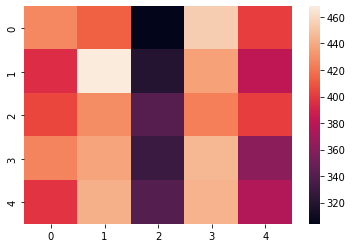

In [ ]:
sn.heatmap(confusionmatrix)

Pour les classes 2 et 4, les résultats ne sont pas satisfaisants. Cependant, on remarque que pour les autres classes, les prédictions semblent plus cohérentes, notamment pour la classe 1.

De plus, voici la matrice de confusion obtenue pour un même modèle mais avec un jeu de données différent (les reviews Amazon de montres) :

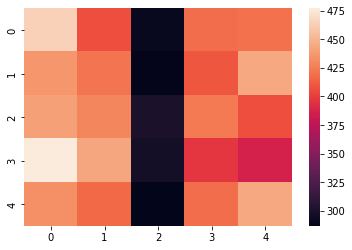

In [ ]:
#matrice de confusion obtenue pour un autre jeu de données